In [1]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from scipy import interpolate
from scipy import integrate
from scipy.optimize import fsolve
import pandas as pd
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table
from ligo.skymap.io import fits
import healpy as hp

import os
from os import listdir
from os.path import isfile, join

from multiprocessing import Pool
import time
from numba import njit

import sys
from tqdm import tqdm

In [2]:
from astropy.cosmology import Planck18
fast=Planck18
fast

FlatLambdaCDM(name="Planck18", H0=67.66 km / (Mpc s), Om0=0.30966, Tcmb0=2.7255 K, Neff=3.046, m_nu=[0.   0.   0.06] eV, Ob0=0.04897)

In [2]:
#-----------------Functions--------------------------
def Mises_Fisher(theta,phi,DS_theta,DS_phi,conc):
    meanvec=hp.ang2vec(DS_theta,DS_phi)
    meanvec=np.asarray(meanvec,dtype=np.float128)
    norm=np.sqrt(np.dot(meanvec,meanvec))
    meanvec=meanvec/norm
    
    var=hp.ang2vec(theta,phi)
    var=np.asarray(var,dtype=np.float128)
    norm=np.sqrt(np.dot(var,var))
    var=var/norm
    
    factor=np.dot(conc*var,meanvec)
    factor=np.float128(factor)
    #Normalization is futile, we will devide by the sum
    #fullnorm=conc/(2*np.pi*(np.exp(conc)-np.exp(-conc)))
    ret=np.float128(np.exp(factor))#/fullnorm
    #ret=factor
    return ret

def z_from_dL(dL_val):
    '''
    Returns redshift for a given luminosity distance dL (in Mpc)'''
    
    func = lambda z :cosmoflag.luminosity_distance(z).value - dL_val
    z = fsolve(func, 0.02)
    return z[0]
def z_from_dcom(dc_val):
    '''
    Returns redshift for a given comoving distance dc (in Mpc)'''
    
    func = lambda z :cosmoflag.comoving_distance(z).value - dc_val
    z = fsolve(func, 0.02)
    return z[0]

@njit
def sphere_uncorr_gauss(x,y,mux,muy,sigx,sigy):
    #correlation is 0 so is a multiplication of two gaussians
    #x is theta, y is phi
    #meanvec=(mux,muy)
    meanvec=np.asarray((1,mux,muy))
    norm=np.sqrt(np.sum(meanvec**2))
    meanvec=meanvec/norm
    
    #var=(x,y)
    var=np.asarray((1,x,y))
    #norm=np.sqrt(np.dot(var,var))
    norm=np.sqrt(np.sum(var**2))
    var=var/norm
    
    diff=meanvec-var
    diff_len=np.sqrt(np.sum(diff**2))
    #xfactor=((x-mux)/sigx)**2
    #yfactor=((y*(1-np.sin(y))-muy*(1-np.sin(muy)))/sigy)**2
    #yfactor=((y-muy)/sigy)**2
    #norm=2*np.pi*sigx*sigy
    factor=((diff_len)/sigy)**2
    ret=np.exp(-(1/2)*(factor))#/norm
    #ret=np.exp(-1/2*(xfactor+yfactor))
    return ret

@njit
def sphere_uncorr_gauss_jacob(phi,theta,phi0,theta0,sigma):
    radius=10
    x = radius * np.sin(theta) * np.cos(phi)
    y = radius * np.sin(theta) * np.sin(phi)
    z = radius * np.cos(theta)
    
    x0 = radius * np.sin(theta0) * np.cos(phi0)-x
    y0 = radius * np.sin(theta0) * np.sin(phi0)-y
    z0 = radius * np.cos(theta0)-z
    
    distances = np.sqrt(x0*x0 + y0*y0 + z0*z0)


    
    # Calculate the Gaussian probability distribution for each point
    prob = 1.0/(sigma*np.sqrt(2*np.pi)) * np.exp(-(distances*distances)/(2*sigma*sigma))
    return prob
    

def gaussian_prob_distribution_on_sphere(phi, theta, phi0, theta0, radius, sigma):
    # If input is a single point, convert to a list
    if isinstance(phi, float) or isinstance(phi, int):
        phi = np.array([phi])
        theta = np.array([theta])

    # Calculate the distance from each point to the fixed point
    distances = np.zeros_like(phi)
    x = radius * np.sin(phi) * np.cos(theta)
    y = radius * np.sin(phi) * np.sin(theta)
    z = radius * np.cos(phi)
    dx = x - radius * np.sin(phi0) * np.cos(theta0)
    dy = y - radius * np.sin(phi0) * np.sin(theta0)
    dz = z - radius * np.cos(phi0)
    distances = np.sqrt(dx*dx + dy*dy + dz*dz)

    # Calculate the Gaussian probability distribution for each point
    prob = 1.0/(sigma*np.sqrt(2*np.pi)) * np.exp(-distances*distances/(2*sigma*sigma))

    # If input was a single point, return a single probability value
    if len(prob) == 1:
        return prob[0]

    return prob

@njit
def E_z(z, H0, Om):
    return np.sqrt(Om*(1+z)**3+(1-Om))

def r_z(z, H0, Om):
    c = clight
    integrand = lambda x : 1/E_z(x, H0, Om)
    integral, error = integrate.quad(integrand, 0, z)
    return integral*c/H0

def Dl_z(z, H0, Om):
    return r_z(z, H0, Om)*(1+z)



#--------------------Posterior Function----------------------------
@njit
def likelihood_line(mu,dl,k):
    sigma=k*dl#true_mu
    norm=1/(np.sqrt(2*np.pi)*sigma)
    body=np.exp(-((dl-mu)**2)/(2*sigma**2))
    ret=norm*body
    return ret

def LikeofH0(iterator):
    i=iterator
    Htemp=H0Grid[i]
    #norm=integrate.quad(lambda x:  FlatLambdaCDM(H0=Htemp, Om0=Om0GLOB).differential_comoving_volume(x).value, 0, 10 )[0]
    #----------computing sum
    to_sum=np.zeros(len(z_gals))
    for j in range(len(z_gals)):
        #dl=FlatLambdaCDM(H0=Htemp, Om0=Om0GLOB).luminosity_distance(z_gals[j]).value
        dl = Dl_z(z_gals[j], Htemp, Om0GLOB)
        #a=0.01
        angular_prob=sphere_uncorr_gauss(new_phi_gals[j],new_theta_gals[j],DS_phi,DS_theta,sigma_phi,sigma_theta)
        to_sum[j]=likelihood_line(mu,dl,s)*angular_prob#*norm
    tmp=np.sum(to_sum)#*norm
    return tmp

@njit
def beta_line(galaxies,z0,z1,zmax):
    denom=len(galaxies[(galaxies>=z0)&(galaxies<=z1)])
    num=len(galaxies[galaxies<=zmax])
    ret=num/denom
    return ret

def multibetaline(iterator):
    i=iterator
    Htemp=H0Grid[i]
    func = lambda z :Dl_z(z, Htemp, Om0GLOB) -(mu+s*5*mu)#25514.6#(mu+s*5*mu)#25729.5 
    zMax = fsolve(func, 0.02)[0] 
    func = lambda z :Dl_z(z, Htemp, Om0GLOB) - (mu-s*5*mu)
    zmin = fsolve(func, 0.02)[0]
    tmp=allz[allz>=zmin]
    tmp=tmp[tmp<=zMax]
    
    gal_invol=len(tmp)
    gal_incat=len(allz[allz<=20])
    if gal_invol==0:
        gal_invol=gal_invol+1

    ret=gal_invol/gal_incat
    return ret


def vol_beta(iterator):
    i=iterator
    Htemp=H0Grid[i]
    cosmo=FlatLambdaCDM(H0=Htemp, Om0=Om0GLOB)
    func = lambda z :Dl_z(z, Htemp, Om0GLOB) - betaHomdMax
    zMax = fsolve(func, 0.02)[0] 
    func = lambda z :Dl_z(z, Htemp, Om0GLOB) - dl_min_beta
    zmin = fsolve(func, 0.02)[0]  
    norm = integrate.quad(lambda x: cosmo.differential_comoving_volume(x).value,zmin,20)[0]
    num = integrate.quad(lambda x:cosmo.differential_comoving_volume(x).value,zmin,zMax)[0]
    return num/norm
def just_vol_beta(iterator):
    i=iterator
    Htemp=H0Grid[i]
    cosmo=FlatLambdaCDM(H0=Htemp, Om0=Om0GLOB)
    func = lambda z :Dl_z(z, Htemp, Om0GLOB) -(mu+s*5*mu)#25514.6#(mu+s*5*mu)#25729.5 
    zMax = fsolve(func, 0.02)[0] 
    func = lambda z :Dl_z(z, Htemp, Om0GLOB) - (mu-s*5*mu)
    zmin = 0 #fsolve(func, 0.02)[0]
    norm = integrate.quad(lambda x: cosmo.differential_comoving_volume(x).value,z1,20)[0]
    num = integrate.quad(lambda x:cosmo.differential_comoving_volume(x).value,zmin,zMax)[0]
    return num/norm

In [4]:
#-----------------Parameter setting--------------------------------
#-----------------------Costants-----------------------------------------
href=67 #69
Om0GLOB=0.319
Xi0Glob =1.
clight = 2.99792458* 10**5#km/s
cosmoflag = FlatLambdaCDM(H0=href, Om0=Om0GLOB)


# Testing our distributions

In [23]:
    cat_name='Flag.txt'
    MyCat = pd.read_csv(cat_name, sep=" ", header=None)
    colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
    MyCat.columns=colnames

In [24]:
allphi=MyCat['phi']
alltheta=MyCat['theta']
alldl=MyCat['Luminosity Distance']
allz=MyCat['z']
alldc=MyCat['Comoving Distance']

zmin=np.min(allz)
zmax=np.max(allz)

dcmin=np.min(alldc)
dcmax=np.max(alldc)

dlmin=np.min(alldl)
dlmax=np.max(alldl)

thetamin=np.min(alltheta)
thetamax=np.max(alltheta)
phimin=np.min(allphi)
phimax=np.max(allphi)
print('Cosmology:')
print('Flat Universe\nHref={},Om={}'.format(href,Om0GLOB))
print('Calalogue Information')
print('theta min={:0.2f}, theta max={:0.2f}, phi min={:0.2f}, phi max={:0.2f}'.format(thetamin,thetamax,phimin,phimax))
print('z min={:0.4f},z max={:0.4f},DC min={:0.4f}cMpc,DC max={:0.4f}cMpc'.format(zmin,zmax,dcmin,dcmax))
print('DL min={:0.4f}Mpl,DL max={:0.4f}Mpc'.format(dlmin,dlmax))

Cosmology:
Flat Universe
Href=67,Om=0.319
Calalogue Information
theta min=0.00, theta max=1.57, phi min=0.00, phi max=1.57
z min=0.7887,z max=2.0129,DC min=2853.2367cMpc,DC max=5345.1357cMpc
DL min=5103.6918Mpl,DL max=16104.5984Mpc


In [25]:
delta_phi=phimax-phimin
theta_part=np.cos(thetamin)-np.cos(thetamax)
integrand=lambda x:clight*(cosmoflag.comoving_distance(x).value)**2/(cosmoflag.H(x).value)
z_part=integrate.quad(integrand,zmin,zmax)[0]

Volume=delta_phi*theta_part*z_part#integrand
print('Cat Volume {} Gpc^3'.format(Volume/1000**3))
Nobj=len(alldc)
Density=Nobj/Volume
print('Cat Density {} #/Mpc^3'.format(Density))

Cat Volume 67.79817302600848 Gpc^3
Cat Density 0.00020719633543238896 #/Mpc^3


In [14]:
0.00059/(2.67/100000)

22.09737827715356

In [8]:
#-----------------test the uniform distribution
position=[]
volume=[]
numobj=[]

Nbis=15
step=(np.max(alldc)-np.min(alldc))/Nbis
start=np.min(alldc)
for i in range(Nbis):
    dcsup=step/2 +start+(step)*i
    position.append(dcsup)
    tmp=alldc[alldc<dcsup]
    numobj.append(len(tmp))
    volume.append(dcsup**3-start**3)# We also sum the missed volume from 0 to zmin
position=np.asarray(position)
volume=np.asarray(volume)
numobj=np.asarray(numobj)
volume=volume/np.min(volume)
norm=numobj[0]
volume=volume*norm

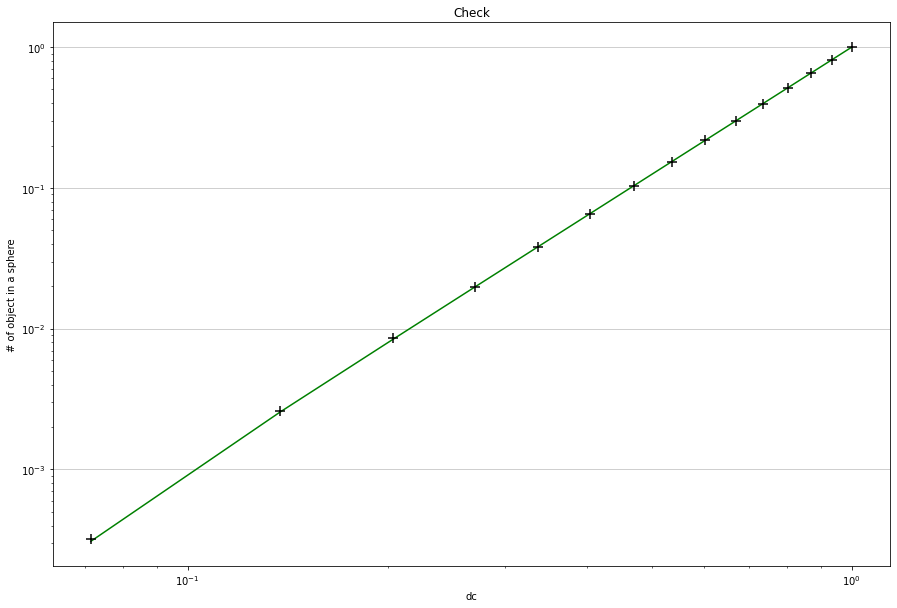

In [9]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(15,10))
#n, bins, patches = plt.hist(x=numobj,grid=True, bins=Num, rwidth=0.9,color='#607c8e')
plt.xscale('log')
plt.yscale('log')
plt.title('Check')
plt.scatter(position/np.max(position),numobj/np.max(numobj),s=100, marker='+', c='k', zorder=10 )

plt.plot(position/np.max(position),volume/np.max(volume),color='g')

plt.xlabel('dc')
plt.ylabel('# of object in a sphere')
plt.grid(axis='y', alpha=0.75)

Text(0.5, 1.0, 'Phi Dist')

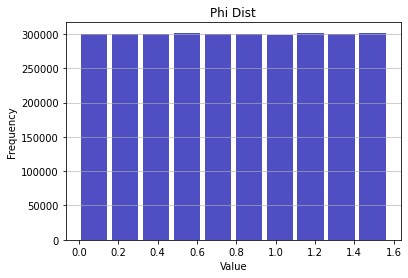

In [10]:
n, bins, patches = plt.hist(x=allphi, bins=10, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Phi Dist')

Text(0.5, 1.0, 'Cos Theta dist')

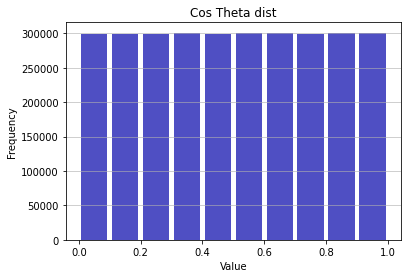

In [11]:
n, bins, patches = plt.hist(x=np.cos(alltheta), bins=10, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Cos Theta dist')

In [24]:
radius_deg= np.sqrt(10/np.pi)
sigma90=radius_deg/np.sqrt(2)
sigma_deg=sigma90/1.5
circle_deg=6*sigma_deg
sigma_theta=np.radians(sigma_deg)
sigma_phi=np.radians(sigma_deg)
radius_rad=np.radians(circle_deg)

phimin=0
phimax=phimin+8.5*sigma_phi
thetamin=0
thetamax=thetamin+8.5*sigma_theta#depends on the arccos 0 to 1 is from pi/2 to 0 -1 to 1 is full range
phicenter=(phimax-phimin)/2 +phimin
thetacenter=(thetamax-thetamin)/2 +thetamin

#phicenter=phimin+(phimax-phimin)/2
#thetacenter=thetamin+(thetamax-thetamin)/2
#theta_test=np.linspace(thetacenter-5*sigma_theta,thetacenter+5*sigma_theta,point)
#phi_test=np.linspace(phicenter-5*sigma_phi,phicenter+5*sigma_phi,point)


In [25]:
print(sigma_deg)

1.1894160774351807


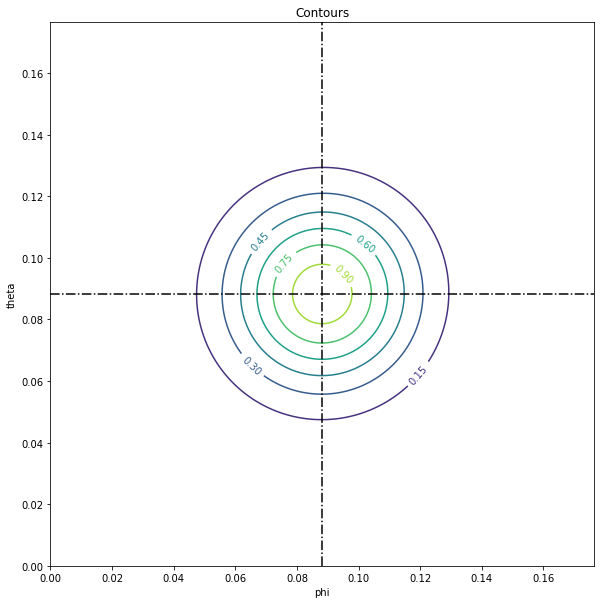

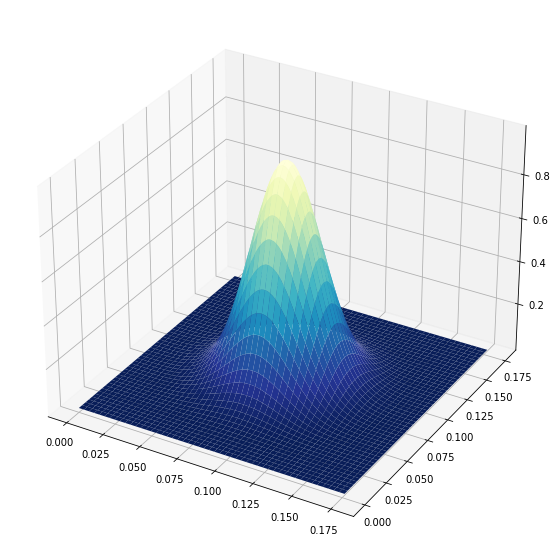

In [26]:
#-----------------------------
import matplotlib.cm as cm
point=1000
theta_test=np.linspace(thetamin,thetamax,point)
phi_test=np.linspace(phimin,phimax,point)
values=np.float128(np.zeros((point,point)))
for i in range(point):
    for j in range(point):
        values[i,j]=sphere_uncorr_gauss(phi_test[i],theta_test[j],phicenter,thetacenter,sigma_phi,sigma_theta)
X,Y=np.meshgrid(phi_test,theta_test)
Z=values
fig, ax = plt.subplots(1,figsize=(10,10))
CS = ax.contour(X, Y, Z)
ax.clabel(CS, inline=True, fontsize=10)
ax.set_aspect('equal', adjustable='box')
ax.axvline(x = phicenter, color = 'k', linestyle='dashdot')
ax.axhline(y = thetacenter, color = 'k', linestyle='dashdot')
ax.set_title('Contours')
ax.set_xlabel('phi')
ax.set_ylabel('theta')

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y, Z, cmap=plt.cm.YlGnBu_r)


In [27]:
import numpy as np
from scipy.integrate import simps

# Definizione dei punti su cui valutare la funzione e dei valori della funzione stessa
point = 1000
theta_test = np.linspace(thetamin, thetamax, point)
phi_test = np.linspace(phimin, phimax, point)
values = np.float128(np.zeros((point, point)))

for i in range(point):
    for j in range(point):
        values[i, j] = sphere_uncorr_gauss(phi_test[i], theta_test[j], phicenter, thetacenter, sigma_phi, sigma_theta)

# Calcola l'integrale della funzione
integral = simps(simps(values, phi_test), theta_test)

# Trova l'area che contiene il 90% della probabilità totale
target_probability = 0.9
target_integral = target_probability * integral

# Inizializza le variabili per calcolare l'area
area = 0.0
i = 0
j = 0

# Calcola l'area finché non raggiungi il 90% dell'integrale totale
while area < target_integral:
    area += values[i, j] * (theta_test[1] - theta_test[0]) * (phi_test[1] - phi_test[0])
    j += 1
    if j == point:
        j = 0
        i += 1

# Converte l'area da rad^2 a deg^2
area_deg2 = area * (180 / np.pi) ** 2  # Conversione da rad^2 a deg^2
print(f"L'area che contiene il {target_probability * 100}% della probabilità totale è: {area_deg2:.4f} deg^2.")


L'area che contiene il 90.0% della probabilità totale è: 8.1980 deg^2.


# Small Runs

In [14]:
#################################DS control room#########################################
NumDS=50
zds_max=1.02
zds_min=0.98
H0min=55#30
H0max=85#140

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

#---------angular stuff------------------
radius_deg= np.sqrt(10/np.pi)
sigma90=radius_deg/np.sqrt(2)
sigma_deg=sigma90/1.5
circle_deg=6*sigma_deg
sigma_theta=np.radians(sigma_deg)
sigma_phi=np.radians(sigma_deg)
radius_rad=np.radians(circle_deg)

thetamin=np.min(alltheta)
thetamax=np.max(alltheta)
phimin=np.min(allphi)
phimax=np.max(allphi)

DS_dlinf=Dl_z(zds_min,href,Om0GLOB)
DS_dlsup=Dl_z(zds_max,href,Om0GLOB)
DS_dlmed=DS_dlinf+(DS_dlsup-DS_dlinf)/2

cutted=MyCat[MyCat['z']<=zds_max]
cutted=cutted[cutted['z']>=zds_min]
cutted=cutted[cutted['phi']<= phimax-10*sigma_phi]
cutted=cutted[cutted['phi']>= phimin+10*sigma_phi]
cutted=cutted[cutted['theta']<= thetamax-10*sigma_theta]
cutted=cutted[cutted['theta']>= thetamin+10*sigma_theta]

sample=cutted.sample(NumDS) #This is the DS cat

#----------------for testing specific DS------------------------------------
dls=np.asarray(cutted['Luminosity Distance'])
mid_dl=find_nearest(dls,DS_dlmed)


#colnames=['Ngal','Comoving Distance','Luminosity Distance','z','phi','theta']
fixed_sample = pd.DataFrame(columns=colnames)

tmp_dl=cutted['Luminosity Distance'].min()
tmp_row=cutted[cutted['Luminosity Distance']==tmp_dl]
fixed_sample=tmp_row

tmp_dl=cutted['Luminosity Distance'].max()
tmp_row=cutted[cutted['Luminosity Distance']==tmp_dl]
fixed_sample=fixed_sample.append(tmp_row,ignore_index=True)


tmp_row=cutted[cutted['Luminosity Distance']==mid_dl]
fixed_sample.append(tmp_row,ignore_index=True)
fixed_sample=fixed_sample.append(tmp_row,ignore_index=True)

#sample=fixed_sample
#NumDS=sample.shape[0]
#---------------------------------------------------------------------------

ds_z=np.asarray(sample['z'])
ds_dl=np.asarray(sample['Luminosity Distance'])
ds_phi=np.asarray(sample['phi'])
ds_theta=np.asarray(sample['theta'])
###################################################################################
#------------------------------A simple check--------------------------------------

print('exteme values of DSs distances:\nDL min={}Mpc, DL med={}Mpc, DL max={}Mpc'.format(DS_dlinf,DS_dlmed,DS_dlsup))
func = lambda z :Dl_z(z, H0min, Om0GLOB) -DS_dlinf*(1-0.1*5)#(mu+s*5*mu)#25514.6#(mu+s*5*mu)#25729.5 
z1 = fsolve(func, 0.02)[0] 
func = lambda z :Dl_z(z, H0max, Om0GLOB) -DS_dlsup*(1+0.1*5)#(mu+s*5*mu)#25514.6#(mu+s*5*mu)#25729.5 
z2 = fsolve(func, 0.02)[0] 
print('Search boundaries in Redshif:')
print('z_inf(minDL,H0min)={} z_sup(maxDL,H0max)={}'.format(z1,z2))

exteme values of DSs distances:
DL min=6659.97662353565Mpc, DL med=6827.788844718981Mpc, DL max=6995.601065902311Mpc
Search boundaries in Redshif:
z_inf(minDL,H0min)=0.4702968112481979 z_sup(maxDL,H0max)=1.7222038354234603


In [68]:
print('exteme values of DSs distances:\nDL min={}Mpc, DL med={}Mpc, DL max={}Mpc'.format(DS_dlinf,DS_dlmed,DS_dlsup))
func = lambda z :Dl_z(z, H0min, Om0GLOB) -1021.09*(1-0.1*5)#(mu+s*5*mu)#25514.6#(mu+s*5*mu)#25729.5 
z1 = fsolve(func, 0.02)[0] 
func = lambda z :Dl_z(z, H0max, Om0GLOB) -1866*(1+0.1*5)#(mu+s*5*mu)#25514.6#(mu+s*5*mu)#25729.5 
z2 = fsolve(func, 0.02)[0] 
print('Search boundaries in Redshif:')
print('z_inf(minDL,H0min)={} z_sup(maxDL,H0max)={}'.format(z1,z2))

exteme values of DSs distances:
DL min=6659.97662353565Mpc, DL med=6827.788844718981Mpc, DL max=6995.601065902311Mpc
Search boundaries in Redshif:
z_inf(minDL,H0min)=0.087969651761551 z_sup(maxDL,H0max)=0.5851023463908392


In [15]:
###################################################################################
#---------------------Start analysis--------------------------------------
H0Grid=np.linspace(H0min,H0max,1000)
arr=np.arange(0,len(H0Grid),dtype=int)
beta=np.zeros(len(H0Grid))
My_Like=np.zeros(len(H0Grid))
dlsigma=0.1
fullrun=[]
allbetas=[]
fullrun_beta=[]
s=dlsigma
###################################Likelihood##################################################
for i in tqdm(range(NumDS)):
    DS_phi=ds_phi[i]
    tmp=MyCat[MyCat['phi']<=DS_phi+5*sigma_phi]
    tmp=tmp[tmp['phi']>=DS_phi-5*sigma_phi]
    DS_theta=ds_theta[i]
    tmp=tmp[tmp['theta']<=DS_theta+5*sigma_theta]
    tmp=tmp[tmp['theta']>=DS_theta-5*sigma_theta]
    true_mu=ds_dl[i]
    mu= np.random.normal(loc=true_mu, scale=true_mu*s, size=None)#ds_dl[i]#
    dsz=ds_z[i]
    dlrange=s*mu*5
    tmp=tmp[tmp['Luminosity Distance']<=mu+dlrange]
    tmp=tmp[tmp['Luminosity Distance']>=mu-dlrange]
    
    z_gals=np.asarray(tmp['z'])
    new_dl_gals=np.asarray(tmp['Luminosity Distance'])
    new_phi_gals=np.asarray(tmp['phi'])
    new_theta_gals=np.asarray(tmp['theta'])
    #print(tmp.shape[0])
    with Pool(14) as p:
        My_Like=p.map(LikeofH0, arr)
        beta=p.map(multibetaline, arr)
    My_Like=np.asarray(My_Like)
    fullrun.append(My_Like)
    beta=np.asarray(beta)
    allbetas.append(beta)


for i in range(NumDS):
    fullrun_beta.append(fullrun[i]/allbetas[i])
combined=[]
for i in range(len(fullrun_beta)):
    #combined=combined+post[i]
    if i==0:
        combined.append(fullrun_beta[i]*1)
    else:
        num=np.float128(combined[i-1]*(fullrun_beta[i]*1))
        combined.append(num)

#############################################################################################

100%|█████████████████████████████████████████████████████████████████████████| 50/50 [31:36<00:00, 37.94s/it]


# Fast Plots

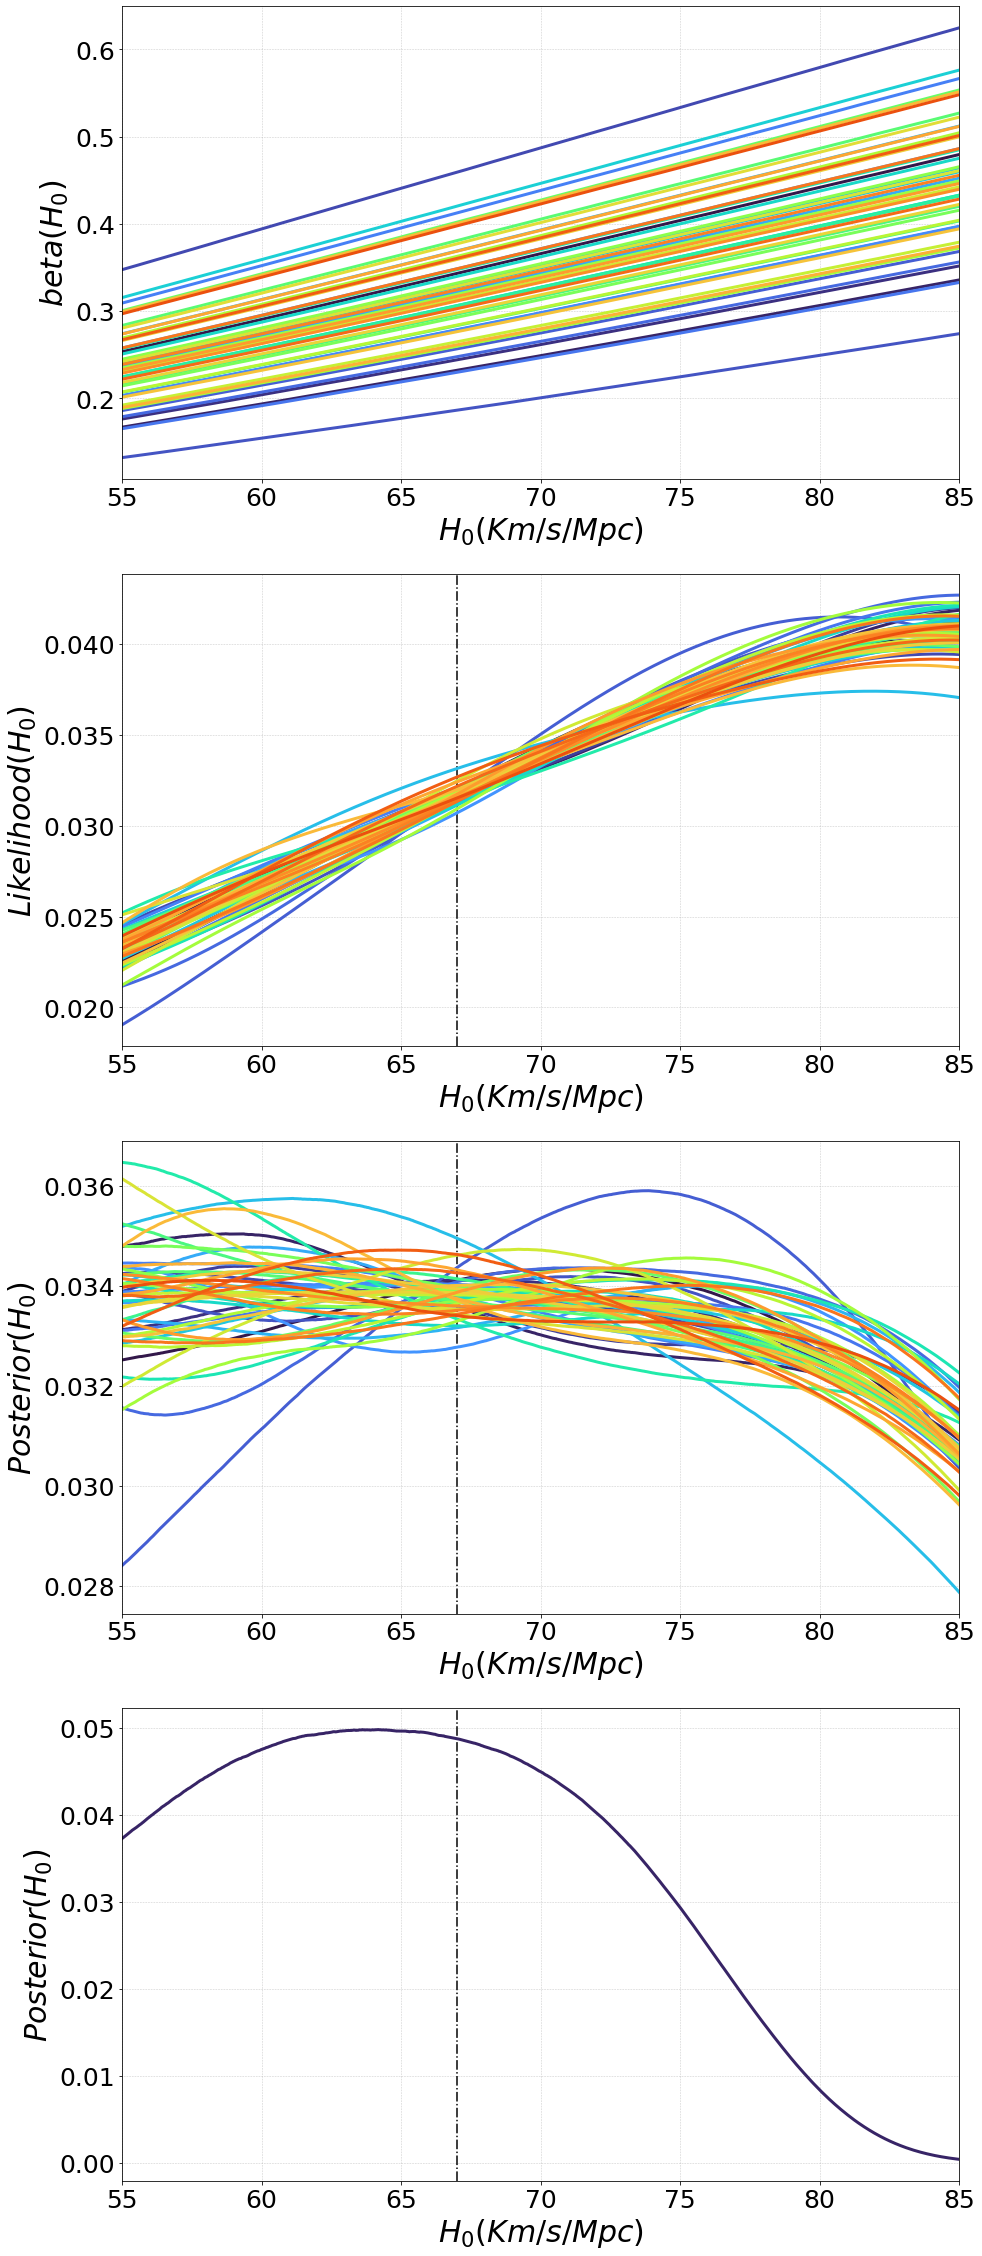

In [16]:
x=H0Grid
xmin=np.min(x)
xmax=np.max(x)
pcol=5
colors=pl.cm.turbo(np.linspace(0.01,0.99,300))
fig, ax = plt.subplots(4, figsize=(15,40)) #crea un tupla che poi è più semplice da gestire
ax[0].tick_params(axis='both', which='major', labelsize=25)
ax[0].yaxis.get_offset_text().set_fontsize(25)
ax[0].grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

ax[0].set_xlim(xmin, xmax)
ax[0].set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax[0].set_ylabel(r'$beta(H_0)$', fontsize=30)

for i in range(len(allbetas)):
    ax[0].plot(x,allbetas[i],color=colors[i*pcol],label='beta '+str(i),linewidth=3)#,label='betatest'+str(i))

#x[0].legend(fontsize=13, ncol=1)   

ax[1].tick_params(axis='both', which='major', labelsize=25)
ax[1].yaxis.get_offset_text().set_fontsize(25)
ax[1].grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

ax[1].set_xlim(xmin, xmax)
ax[1].set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax[1].set_ylabel(r'$Likelihood(H_0)$', fontsize=30)
ax[1].axvline(x = href, color = 'k', linestyle='dashdot',label = 'H0=67')
for i in range(len(allbetas)):
    ax[1].plot(x,fullrun[i]/np.trapz(fullrun[i],x),color=colors[i*pcol],label='Like '+str(i),linewidth=3)#,label='betatest'+str(i))

#x[1].legend(fontsize=13, ncol=1)  

ax[2].tick_params(axis='both', which='major', labelsize=25)
ax[2].yaxis.get_offset_text().set_fontsize(25)
ax[2].grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

ax[2].set_xlim(xmin, xmax)
ax[2].set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax[2].set_ylabel(r'$Posterior(H_0)$', fontsize=30)
ax[2].axvline(x = href, color = 'k', linestyle='dashdot',label = 'H0=67')
for i in range(len(allbetas)):
    ax[2].plot(x,fullrun_beta[i]/np.trapz(fullrun_beta[i],x),color=colors[i*pcol],label='Post '+str(i),linewidth=3)#,label='betatest'+str(i))

#x[2].legend(fontsize=13, ncol=1)  

ax[3].tick_params(axis='both', which='major', labelsize=25)
ax[3].yaxis.get_offset_text().set_fontsize(25)
ax[3].grid(linestyle='dotted', linewidth='0.6')#griglia in sfondo

ax[3].set_xlim(xmin, xmax)
ax[3].set_xlabel(r'$H_0(Km/s/Mpc)$', fontsize=30)
#ax.set_ylabel(r'$P(H_0)$', fontsize=20)
ax[3].set_ylabel(r'$Posterior(H_0)$', fontsize=30)
ax[3].axvline(x = href, color = 'k', linestyle='dashdot',label = 'H0=67')
ax[3].plot(x,combined[-1]/np.trapz(combined[-1],x),color=colors[pcol],label='Post_combined ',linewidth=3)#,label='betatest'+str(i))

#[3].legend(fontsize=13, ncol=1)  

In [55]:
    mu= 17941.6
    s=0.1
    func = lambda z :Dl_z(z, 67, Om0GLOB) - (mu+s*3.5*mu)
    z = fsolve(func, 0.02)[0]
    
    print(z)

2.8205880582861993


In [34]:
dlMAX=Dl_z(2,67,0.319)
dlMIN=Dl_z(0.8,67,0.319)
zMAX=2
zMIN=0.8
print(dlMIN,dlMAX)
print(zMIN,zMAX)

5192.923712715405 15978.58171803367
0.8 2


In [57]:
dl=Dl_z(0.08,67,0.319)#10508
sigma=0.1
dlrange=sigma*3.5*dl
dL_val=dl+dlrange
func = lambda z :Dl_z(z,85,0.319) - dL_val
z = fsolve(func, 0.02)[0]
print(z)

dL_val=dl-dlrange
func = lambda z :Dl_z(z,55,0.319) - dL_val
z = fsolve(func, 0.02)[0]
print(z)
func = lambda z :Dl_z(z,85,0.319) - dL_val
z = fsolve(func, 0.02)[0]
print(z)

0.13241862013133154
0.04377339725858997
0.06657725181108323


In [40]:
dl=10145.5
sigma=0.1
dlrange=sigma*5*dl
dL_val=dl+dlrange
func = lambda z :Dl_z(z,85,0.319) - dL_val
z = fsolve(func, 0.02)[0]
print(z)

dL_val=dl-dlrange
func = lambda z :Dl_z(z,55,0.319) - dL_val
z = fsolve(func, 0.02)[0]
print(z)

2.3371822397007964
0.6674382038346601


In [49]:
Htemp=80
cosmo=FlatLambdaCDM(H0=Htemp, Om0=Om0GLOB)
integrand=lambda x:clight*(cosmo.comoving_distance(x).value)**2/(cosmo.H(x).value)
z_part=integrate.quad(integrand,0,20)[0]
print(z_part)

integrand=lambda x:clight*r_z(x,Htemp,Om0GLOB)**2/(cosmo.H(x).value)
z_part=integrate.quad(integrand,0,20)[0]
print(z_part)

258245781581.39923
258245781581.39914


In [9]:
#---------angular stuff------------------
radius_deg= np.sqrt(20/np.pi)
sigma90=radius_deg/np.sqrt(2)
sigma_deg=sigma90/1.5
circle_deg=6*sigma_deg
sigma_theta=np.radians(sigma_deg)
sigma_phi=np.radians(sigma_deg)
radius_rad=np.radians(circle_deg)
print(sigma_phi)

0.020759226727399736


In [11]:
0.0207*3.5

0.07245